# PyTorch 介绍

### 来自李宏毅老师的课程, 稍有改动，将CNN部分替换为torchtext的演示
##### [原notebook地址](https://colab.research.google.com/drive/1Xed5YSpLsLfkn66OhhyNzr05VE89enng#scrollTo=aSO1McZLMTiT)

主要内容:
- 自动微分
- 常见函数
- 使用DataSet
- Mixed Presision Training in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np

torch.manual_seed(446)
np.random.seed(446)

## Tensors and relation to numpy
Pytorch中的`tensor`可类比为numpy中的`ndarry`,有类似的操作

In [2]:
# 类似的对象创建操作
x_numpy = np.array([0.1, 0.2, 0.3])
x_torch = torch.tensor([0.1, 0.2, 0.3])
print('x_numpy, x_torch')
print(x_numpy, x_torch)
print()

# numpy和pytorch对象的相互转换
print('to and from numpy and pytorch')
print(torch.from_numpy(x_numpy), x_torch.numpy())
print()

# 元素级别的 +-*/ 运算
y_numpy = np.array([3,4,5.])
y_torch = torch.tensor([3,4,5.])
print("x+y")
print(x_numpy + y_numpy, x_torch + y_torch)
print()

# numpy实现的一些运算也可在pytorch中找到
print("norm")
print(np.linalg.norm(x_numpy), torch.norm(x_torch))
print()

# 沿着某个维度操作,
# pytorch 用 dim=?
# numpy 使用 axis=?
print("mean along the 0th dimension")
x_numpy = np.array([[1,2],[3,4.]])
x_torch = torch.tensor([[1,2],[3,4.]])
print(np.mean(x_numpy, axis=0), torch.mean(x_torch, dim=0))


x_numpy, x_torch
[0.1 0.2 0.3] tensor([0.1000, 0.2000, 0.3000])

to and from numpy and pytorch
tensor([0.1000, 0.2000, 0.3000], dtype=torch.float64) [0.1 0.2 0.3]

x+y
[3.1 4.2 5.3] tensor([3.1000, 4.2000, 5.3000])

norm
0.37416573867739417 tensor(0.3742)

mean along the 0th dimension
[2. 3.] tensor([2., 3.])


### [`Tensor.view`](https://pytorch.org/docs/master/tensors.html#torch.Tensor.view)
类似 `numpy.reshape()`，可以使用`Tensor.view()` 函数改变tensor的形状
当传入-1时，它可以自动确定维度。可应用于批处理时Batch size未知的场景。


In [ ]:
# "MNIST"
N, C, W, H = 10000, 3, 28, 28
X = torch.randn((N, C, W, H))

print(X.shape)
print(X.view(N, C, 784).shape)
print(X.view(-1, C, 784).shape) # 自动判定0维度

torch.Size([10000, 3, 28, 28])
torch.Size([10000, 3, 784])
torch.Size([10000, 3, 784])


### [`BROADCASTING SEMANTICS`](https://pytorch.org/docs/stable/notes/broadcasting.html)
两个tensors可以 “broadcastable” 的条件:

- 每个tensor至少有一个维度.
- 对两个tensor的shape tuple，从末尾向前遍历它们的维数, 每对维度大小要满足以下情形之一：
  - 两个维数相等
  - 某个维数为1
  - 某个维数不存在

In [3]:
# PyTorch 运算支持 NumPy的 Broadcasting Semantics.
x=torch.empty(5,1,4,1)
y=torch.empty(  3,1,1)
print((x+y).size())

torch.Size([5, 3, 4, 1])


## 计算图

Pytorch和Numpy的最大不同在于tensor的运算过程会自动建立计算图. 计算图可以表达数学运算的逻辑. 同时，所有图中变量的梯度都会被自动计算获得。

以如下算式为例： $e=(a+b)*(b+1)$，假设a, b取值$a=2, b=1$， 我们可以画出对应的计算图
<br>
<br>

我们可以用PyTorch计算得到：

![tree-img](https://colah.github.io/posts/2015-08-Backprop/img/tree-eval.png)

[source](https://colah.github.io/posts/2015-08-Backprop/)

In [4]:
a = torch.tensor(2.0, requires_grad=True) # 设参数requires_grad=True 可强制Pytorch为tensor计算梯度。
b = torch.tensor(1.0, requires_grad=True)
c = a + b
d = b + 1
e = c * d
print('c', c)
print('d', d)
print('e', e)

c tensor(3., grad_fn=<AddBackward0>)
d tensor(2., grad_fn=<AddBackward0>)
e tensor(6., grad_fn=<MulBackward0>)


可以看到Pytorch记录了计算过程（计算图）

### [CUDA SEMANTICS](https://pytorch.org/docs/stable/notes/cuda.html)
数据可自由在cpu和gpu间中转移

In [5]:
cpu = torch.device("cpu")
gpu = torch.device("cuda")

x = torch.rand(10)
print(x)
x = x.to(gpu)
print(x)
x = x.to(cpu)
print(x)

tensor([0.2010, 0.5419, 0.0024, 0.3200, 0.1604, 0.6338, 0.5056, 0.5847, 0.8565,
        0.0176])
tensor([0.2010, 0.5419, 0.0024, 0.3200, 0.1604, 0.6338, 0.5056, 0.5847, 0.8565,
        0.0176], device='cuda:0')
tensor([0.2010, 0.5419, 0.0024, 0.3200, 0.1604, 0.6338, 0.5056, 0.5847, 0.8565,
        0.0176])


## 作为自动微分框架的PyTorch

令$f(x) = (x-2)^2$.

任务: 求函数导数 $\frac{d}{dx} f(x)$ 在$x=1$时的取值 $f'(1)$.

如果我们利用pytorch写出函数$y=f(x)$, 并且传入$x=1$，那么可以得到相应的结果y（也是一个tensor）。 调用y的 `backward()` 函数, 所有变量的梯度都可以自动求解得到.

In [6]:
def f(x):
    return (x-2)**2

def fp(x):
    return 2*(x-2)

x = torch.tensor([1.0], requires_grad=True)

y = f(x)
y.backward()

print('Analytical f\'(x):', fp(x))
print('PyTorch\'s f\'(x):', x.grad)


Analytical f'(x): tensor([-2.], grad_fn=<MulBackward0>)
PyTorch's f'(x): tensor([-2.])


对于参数更多的函数的梯度计算也类似

令 $w = [w_1, w_2]^T$

设有函数 $g(w) = 2w_1w_2 + w_2\cos(w_1)$

任务: 计算 $\nabla_w g(w)$ 并验证 $\nabla_w g([\pi,1])$

In [7]:
def g(w):
    return 2*w[0]*w[1] + w[1]*torch.cos(w[0])

def grad_g(w):
    return torch.tensor([2*w[1] - w[1]*torch.sin(w[0]), 2*w[0] + torch.cos(w[0])])

w = torch.tensor([np.pi, 1], requires_grad=True)

z = g(w)
z.backward()

print('Analytical grad g(w)', grad_g(w))
print('PyTorch\'s grad g(w)', w.grad)


Analytical grad g(w) tensor([2.0000, 5.2832])
PyTorch's grad g(w) tensor([2.0000, 5.2832])


## 使用梯度

任务: 利用梯度下降算法求解使得$f$最小化的 $x$。

In [ ]:
x = torch.tensor([5.0], requires_grad=True)
step_size = 0.25

print('iter,\tx,\tf(x),\tf\'(x),\tf\'(x) pytorch')
for i in range(15):
    y = f(x)
    y.backward() # 计算梯度
    
    print('{},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f}'.format(i, x.item(), f(x).item(), fp(x).item(), x.grad.item()))
    
    x.data = x.data - step_size * x.grad # 进行一步梯度下降
    
    # 我们需要清空梯度，因为调用backward()
    # 会累积每个变量.grad中的梯度，而不是覆盖重写.
    x.grad.detach_()
    x.grad.zero_()

iter,	x,	f(x),	f'(x),	f'(x) pytorch
0,	5.000,	9.000,	6.000,	6.000
1,	3.500,	2.250,	3.000,	3.000
2,	2.750,	0.562,	1.500,	1.500
3,	2.375,	0.141,	0.750,	0.750
4,	2.188,	0.035,	0.375,	0.375
5,	2.094,	0.009,	0.188,	0.188
6,	2.047,	0.002,	0.094,	0.094
7,	2.023,	0.001,	0.047,	0.047
8,	2.012,	0.000,	0.023,	0.023
9,	2.006,	0.000,	0.012,	0.012
10,	2.003,	0.000,	0.006,	0.006
11,	2.001,	0.000,	0.003,	0.003
12,	2.001,	0.000,	0.001,	0.001
13,	2.000,	0.000,	0.001,	0.001
14,	2.000,	0.000,	0.000,	0.000


# 线性回归

用以上的技术求解线性回归问题

In [8]:
# 生成训练数据集

d = 2
n = 50
X = torch.randn(n,d)
true_w = torch.tensor([[-1.0], [2.0]])
y = X @ true_w + torch.randn(n,1) * 0.1
print('X shape', X.shape)
print('y shape', y.shape)
print('w shape', true_w.shape)


X shape torch.Size([50, 2])
y shape torch.Size([50, 1])
w shape torch.Size([2, 1])


### 关于tensor维度
Pytorch中的习惯是将数据准备成$(N, d)$的维度， 其中$N$是batch大小

### Ground Truth
线性回归的残差平方和目标函数的梯度：

$$\nabla_w \mathcal{L}_{RSS}(w; X) = \nabla_w\frac{1}{n} ||y - Xw||_2^2 = -\frac{2}{n}X^T(y-Xw)$$

In [9]:
# 定义一个简单的线性模型
def model(X, w):
    return X @ w

# 线性回归的残差平方和目标函数
def rss(y, y_hat):
    return torch.norm(y - y_hat)**2 / n

# 梯度的分析解 @ 为矩阵乘法
def grad_rss(X, y, w):
    return -2*X.t() @ (y - X @ w) / n

w = torch.tensor([[1.], [0]], requires_grad=True)
y_hat = model(X, w)

loss = rss(y, y_hat)
loss.backward()

print('Analytical gradient', grad_rss(X, y, w).detach().view(2).numpy())
print('PyTorch\'s gradient', w.grad.view(2).numpy())


Analytical gradient [ 3.414288 -3.953939]
PyTorch's gradient [ 3.414288 -3.953939]


事实证明Pytorch计算出的梯度是正确的。我们接下来用自动梯度来做梯度下降。

## 利用pytorch自动求解的梯度来学习线性回归模型

注意: 本例为手动求解的展示，更符合pytorch风格的方式会在后面介绍


In [ ]:
step_size = 0.1

print('iter,\tloss,\tw')
for i in range(20):
    y_hat = model(X, w)
    loss = rss(y, y_hat)
    
    loss.backward() # 计算当前loss对每个参数的梯度
    
    w.data = w.data - step_size * w.grad # 进行一步梯度下降
    
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), w.view(2).detach().numpy()))
    
    # 我们需要清空梯度，因为调用backward()
    # 会累积每个变量.grad中的梯度，而不是覆盖重写.
    w.grad.detach()
    w.grad.zero_()

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', w.view(2).detach().numpy())

iter,	loss,	w
0,	7.82,	[0.13149136 0.70046324]
1,	2.84,	[-0.11822014  0.9229876 ]
2,	1.84,	[-0.31444427  1.1054724 ]
3,	1.19,	[-0.4684834  1.2552956]
4,	0.77,	[-0.58927345  1.3784461 ]
5,	0.50,	[-0.68387645  1.4797904 ]
6,	0.33,	[-0.75787055  1.563287  ]
7,	0.22,	[-0.8156596  1.632159 ]
8,	0.15,	[-0.86071837  1.6890337 ]
9,	0.10,	[-0.89578694  1.736055  ]
10,	0.07,	[-0.9230244  1.7749742]
11,	0.05,	[-0.94413096  1.8072236 ]
12,	0.03,	[-0.9604442  1.8339758]
13,	0.02,	[-0.9730157  1.8561921]
14,	0.02,	[-0.9826713  1.8746614]
15,	0.01,	[-0.99005884  1.8900318 ]
16,	0.01,	[-0.99568594  1.9028363 ]
17,	0.01,	[-0.99994993  1.913514  ]
18,	0.01,	[-1.0031612  1.9224268]
19,	0.01,	[-1.0055621  1.9298735]

true w		 [-1.  2.]
estimated w	 [-1.0055621  1.9298735]


## [torch.nn.Module](https://pytorch.org/docs/master/generated/torch.nn.Module.html)

`Module` 是PyTorch用来组织tensor运算的类，自定义Module可以继承`torch.nn.Module`类实现. 常用的神经网络模型都是`Module`的子类。所有的`Module`类实例都可被调用，也可被组织为更复杂的运算模块.



### Linear Module (torch.nn.Linear)
Linear Module可理解为一个全连接层：对输入向量进行线性变换（加上bias）
`torch.nn.Linear(in_features, out_features, bias = True)`

和我们之前手工创建和维护的参数变量$w$不同，Linear module可以自动创建和初始化参数。如果需要手动初始化参数，可以使用`torch.nn.init`中实现的初始化方法.

[`torch.nn.init` docs](https://pytorch.org/docs/stable/nn.html#torch-nn-init)

In [10]:
d_in = 3
d_out = 4
linear_module = nn.Linear(d_in, d_out)

example_tensor = torch.tensor([[1.,2,3], [4,5,6]])
# 对输入数据进行线性转换
transformed = linear_module(example_tensor)
print('example_tensor', example_tensor.shape)
print('transormed', transformed.shape)
print()
print('自动创建和维护的参数权重\n')
print('W:', linear_module.weight)
print('b:', linear_module.bias)

example_tensor torch.Size([2, 3])
transormed torch.Size([2, 4])

自动创建和维护的参数权重

W: Parameter containing:
tensor([[ 0.2270, -0.0063,  0.1384],
        [-0.1959, -0.2587,  0.0353],
        [ 0.5478, -0.5734,  0.2589],
        [ 0.5739, -0.4392, -0.0377]], requires_grad=True)
b: Parameter containing:
tensor([0.2290, 0.0529, 0.4021, 0.3153], requires_grad=True)


### 激活函数
PyTorch 实现了常见激活函数，例如`ReLU`, `Tanh`, 和 `Sigmoid`.

In [11]:
activation_fn = nn.ReLU() # 实例化一个ReLU module
example_tensor = torch.tensor([-1.0, 1.0, 0.0])
activated = activation_fn(example_tensor)
print('example_tensor', example_tensor)
print('activated', activated)

example_tensor tensor([-1.,  1.,  0.])
activated tensor([0., 1., 0.])


### Sequential

`torch.nn.Sequential`可以用来组合一系列的Module，以构建和维护更复杂的模型。

In [12]:
d_in = 3
d_hidden = 4
d_out = 1
model = torch.nn.Sequential(
                            nn.Linear(d_in, d_hidden),
                            nn.Tanh(),
                            nn.Linear(d_hidden, d_out),
                            nn.Sigmoid()
                           )

example_tensor = torch.tensor([[1.,2,3],[4,5,6]])
transformed = model(example_tensor)
print('transformed', transformed.shape)

transformed torch.Size([2, 1])


*注意*: 我们可以访问Sequential中的所有的`nn.Module`参数，方法是调用Sequential实例的`parameters()` method. 

In [ ]:
params = model.parameters()

for param in params:
    print(param)

Parameter containing:
tensor([[-0.3128,  0.2707, -0.3952],
        [ 0.1285,  0.1777, -0.4675],
        [ 0.0452, -0.5630, -0.1999],
        [ 0.5431,  0.0524,  0.1126]], requires_grad=True)
Parameter containing:
tensor([ 0.2683, -0.2361,  0.2769, -0.1380], requires_grad=True)
Parameter containing:
tensor([[ 0.4902, -0.0928, -0.2907,  0.0734]], requires_grad=True)
Parameter containing:
tensor([-0.0394], requires_grad=True)


### Loss functions
PyTorch 实现了许多常见的loss functions，包括回归模型的`MSELoss` 和分类模型的 `CrossEntropyLoss`.

In [ ]:
mse_loss_fn = nn.MSELoss()

output = torch.tensor([[0., 0, 0]])
target = torch.tensor([[1., 0, -1]])

loss = mse_loss_fn(output, target)

print(loss)

tensor(0.6667)


## torch.optim
PyTorch 在`torch.optim`中实现了常见的基于梯度的优化方法, 包括 Gradient Descent.

需要注意的是Optimizers不负责计算模型参数的梯度，因此我们必须首先对最终loss tensor执行`backward()`以计算梯度。

零一点要注意的是在执行`backward()`之前需要利用`optim.zero_grad()`清空每个模型参数的梯度，因为默认情况下，pytorch会对每个模型参数累加其梯度，而不是用新计算得到的梯度覆盖掉上一时刻的梯度。

`optim.zero_grad()`会对每个模型参数变量执行`detach_()` 和 `zero_()`.

[`torch.optim` docs](https://pytorch.org/docs/stable/optim.html)

In [ ]:
# 创建一个简单模型
model = nn.Linear(1, 1)

# 创建一个简单数据集
X_simple = torch.tensor([[1.]])
y_simple = torch.tensor([[2.]])

# 实例化我们的优化器
optim = torch.optim.SGD(model.parameters(), lr=1e-2)
mse_loss_fn = nn.MSELoss()

y_hat = model(X_simple)
print('model params before:', model.weight)
loss = mse_loss_fn(y_hat, y_simple)
optim.zero_grad()
loss.backward()

optim.step()
print('model params after:', model.weight)


model params before: Parameter containing:
tensor([[-0.4950]], requires_grad=True)
model params after: Parameter containing:
tensor([[-0.4427]], requires_grad=True)


可见模型参数的更新方向是正确的。



## 利用纯pytorch的风格来训练线性回归模型


In [ ]:
step_size = 0.1

linear_module = nn.Linear(d, 1, bias=False)

loss_func = nn.MSELoss()

optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)

print('iter,\tloss,\tw')

for i in range(20):
    y_hat = linear_module(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(2).detach().numpy()))

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', linear_module.weight.view(2).detach().numpy())

iter,	loss,	w
0,	2.99,	[-0.5453574   0.51412684]
1,	2.02,	[-0.666086    0.75222915]
2,	1.37,	[-0.75831056  0.9504565 ]
3,	0.94,	[-0.82842976  1.1156546 ]
4,	0.64,	[-0.8814486  1.2534634]
5,	0.44,	[-0.92127615  1.3685349 ]
6,	0.31,	[-0.9509604  1.4647106]
7,	0.22,	[-0.9728737  1.5451664]
8,	0.15,	[-0.98885876  1.6125307 ]
9,	0.11,	[-1.0003437  1.6689818]
10,	0.08,	[-1.0084321  1.7163262]
11,	0.06,	[-1.0139749  1.7560644]
12,	0.04,	[-1.0176253  1.7894436]
13,	0.03,	[-1.0198835  1.8175017]
14,	0.02,	[-1.0211303  1.8411033]
15,	0.02,	[-1.0216544  1.8609697]
16,	0.02,	[-1.0216731  1.8777025]
17,	0.01,	[-1.0213491  1.8918046]
18,	0.01,	[-1.020803   1.9036964]
19,	0.01,	[-1.020123   1.9137299]

true w		 [-1.  2.]
estimated w	 [-1.020123   1.9137299]


## 随机梯度下降训练线性回归
前一个例子我们使用的是Full-batch梯度下降. 我们稍作修改可以实现SGD版本的线性回归

In [ ]:
step_size = 0.01

linear_module = nn.Linear(d, 1)
loss_func = nn.MSELoss()
optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)
print('iter,\tloss,\tw')
for i in range(200):
    rand_idx = np.random.choice(n) # 每一步从训练集和中取出一个样本
    x = X[rand_idx] 
    y_hat = linear_module(x)
    loss = loss_func(y_hat, y[rand_idx]) # 只计算单个样本的loss
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % 20 == 0:
        print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(2).detach().numpy()))

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', linear_module.weight.view(2).detach().numpy())

iter,	loss,	w
0,	4.46,	[-0.20530997  0.66900945]
20,	1.28,	[-0.34921718  0.8908058 ]
40,	0.73,	[-0.513422   1.1883926]
60,	0.51,	[-0.6704745  1.5351907]
80,	0.16,	[-0.7813061  1.6464837]
100,	0.20,	[-0.8568147  1.7569876]
120,	0.03,	[-0.90830195  1.8347709 ]
140,	0.00,	[-0.9449066  1.888105 ]
160,	0.00,	[-0.96574944  1.9163204 ]
180,	0.01,	[-0.98202056  1.9221277 ]

true w		 [-1.  2.]
estimated w	 [-0.98299205  1.9443793 ]


# Neural Network Basics in PyTorch
用一个简单的神经网络(MLP)来拟合数据


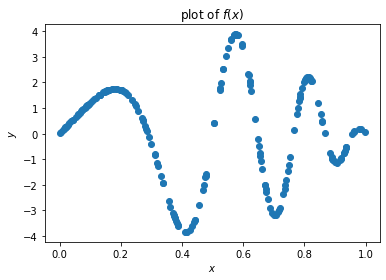

In [ ]:
%matplotlib inline

d = 1
n = 200
X = torch.rand(n,d)
y = 4 * torch.sin(np.pi * X) * torch.cos(6*np.pi*X**2)

plt.scatter(X.numpy(), y.numpy())
plt.title('plot of $f(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

我们定义一个由两个隐层和tanh激活函数构成的前馈神经网络。超参数的变化会影响你和的结果。

In [ ]:
# 可调节参数以观察拟合结果的变化

step_size = 0.05
n_epochs = 6000
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
                            nn.Linear(d, n_hidden_1), 
                            nn.Tanh(),
                            nn.Linear(n_hidden_1, n_hidden_2),
                            nn.Tanh(),
                            nn.Linear(n_hidden_2, d_out)
                            )

loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size)
print('iter,\tloss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))



iter,	loss
0,	3.99
600,	3.70
1200,	2.45
1800,	1.13
2400,	0.93
3000,	0.70
3600,	0.29
4200,	0.09
4800,	0.08
5400,	0.07


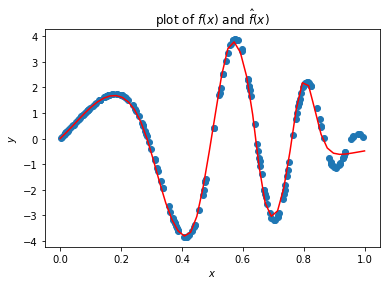

In [ ]:
X_grid = torch.from_numpy(np.linspace(0,1,50)).float().view(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(X_grid.detach().numpy(), y_hat.detach().numpy(), 'r')
plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

# 可能有益的技术

## 动量 （Momentum）

随机梯度下降+动量,可以在一定程度上增加稳定性，从而学习地更快，并且还有一定摆脱局部最优的能力。更多讨论可参考[here](https://distill.pub/2017/momentum/).

在下面的例子中，我们使用了带动量sgd，可以观察到损失的下降比上例要快许多。

In [ ]:
# 可调节参数以观察拟合结果的变化

step_size = 0.05
momentum = 0.9
n_epochs = 1500
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
                            nn.Linear(d, n_hidden_1), 
                            nn.Tanh(),
                            nn.Linear(n_hidden_1, n_hidden_2),
                            nn.Tanh(),
                            nn.Linear(n_hidden_2, d_out)
                            )

loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size, momentum=momentum)
print('iter,\tloss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))



iter,	loss
0,	3.98
150,	2.77
300,	0.84
450,	0.26
600,	0.06
750,	0.05
900,	0.01
1050,	0.00
1200,	0.00
1350,	0.00


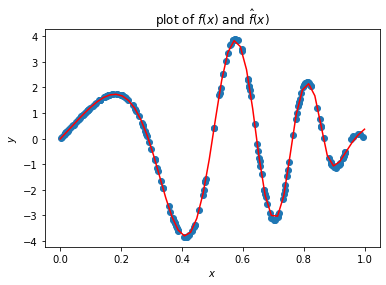

In [ ]:
X_grid = torch.from_numpy(np.linspace(0,1,50)).float().view(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(X_grid.detach().numpy(), y_hat.detach().numpy(), 'r')
plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

## CrossEntropyLoss
上面的例子主要是回归任务，损失函数我们用的是 [MSELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.MSELoss) module. .

对于分类任务，我们可以使用PyTorch实现的[CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). 

- output: 第一个函数参数是分类模型的输出结果，一个维度为$(N,C)$的*float* tensor，其中$N$是batch size，$C$是类别的数量. 在下面的例子中，我们有$N=3$ 和 $C=2$。 第二维中的$C$个预测值是非规范化的预测分数， CrossEntropyLoss module会自动做softmax, 所以我们不必手动做。
- target: 第二个函数参数是真实标签的tenser，必须是维度为 $(N)$的*整数* tensor. 每个元素指代正确类别标签. 在我们下面的例子当中，类别标签是1和0.

尝试下面的三预测的损失。真实类别标签是 $y=[1,1,0]$. 前两个预测对应于正确标签，但第二个confidence比第一个高，因此loss会更小。后两个预测是错误相同的预测结果，其中后者比前者错得更严重一些，因此损失会更大.

In [15]:
loss = nn.CrossEntropyLoss()

# input = torch.tensor([[-1., 1],[-1, 1],[1, -1]]) # 预测分数对应正确类别
# print(input)
input = torch.tensor([[-3., 3],[-3, 3],[3, -3]]) # 预测分数对应正确类别，比上一个有更高的confidence
# print(input)
# input = torch.tensor([[1., -1],[1, -1],[-1, 1]]) # 预测分数对应错误类别
# print(input)
# input = torch.tensor([[3., -3],[3, -3],[-3, 3]]) # 预测分数对应错误类别，比上一个错得更绝对
# print(input)

target = torch.tensor([1, 1, 0])
output = loss(input, target)
print(output)
#tensor(0.1269)

tensor(0.0025)


## Learning rate schedulers

我们通常希望在不同的训练时期使用不同的学习率（开始时大，随时间衰减）。
PyTorch 实现了一些学习率的schedulers,可以在每次梯度下降后调用，学习率会相应的发生变化。参考 [学习率scheduler的文档](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

# 使用TorchText实现文本分类任务

TorchText封装了一些文本数据处理的功能，包括加载、预处理和batching操作

参考[教程](https://github.com/keitakurita/practical-torchtext/blob/master/Lesson%201%20intro%20to%20torchtext%20with%20text%20classification.ipynb)

In [16]:
from torchtext.data import Field
from torchtext.data import Iterator, BucketIterator
from torchtext.data import TabularDataset
import pandas as pd

In [17]:
pd.read_csv("data/train.csv").head(2)

FileNotFoundError: ignored

In [ ]:
pd.read_csv("data/valid.csv").head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,000eefc67a2c930f,Radial symmetry \n\nSeveral now extinct lineag...,0,0,0,0,0,0
1,000f35deef84dc4a,There's no need to apologize. A Wikipedia arti...,0,0,0,0,0,0


In [ ]:
pd.read_csv("data/test.csv").head(2)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...


## 使用Fields类
Fields 类确定如何对数据进行预处理并转化为数值型的输入。
在下面的例子中，
- 我们希望对"comment_text" 本做转化为小写、以空格tokenize等预处理操作。
- 对于标签列，由于已经处理为binary，我们可以通过传入use_vocab=False告诉Fileds不用再处理

In [ ]:
tokenize = lambda x: x.split()
TEXT = Field(sequential=True, tokenize=tokenize, lower=True)
LABEL = Field(sequential=False, use_vocab=False)

# 构造Dataset
因为我们的数据集为.csv格式，所以可以使用`TabularDataset`类读取数据

我们输入一个tuple序列，其中每个tuple对应.csv数据集中的列，顺序严格对齐。

In [ ]:
tv_datafields = [("id", None), # 对于.csv中不使用的列，可以用None来标识， 其他的列用我们之前定义的Filed类来声明类别
                 ("comment_text", TEXT), ("toxic", LABEL),
                 ("severe_toxic", LABEL), ("threat", LABEL),
                 ("obscene", LABEL), ("insult", LABEL),
                 ("identity_hate", LABEL)]

trn, vld = TabularDataset.splits(
        path="data", # 数据集的根目录
        train='train.csv', validation="valid.csv",
        format='csv',
        skip_header=True, # 如果数据集有header,确保跳过header,否则第一行header也会被作为数据读入
        fields=tv_datafields)      


tst_datafields = [("id", None), # 不使用id列
                 ("comment_text", TEXT)
]

tst = TabularDataset(
        path="data/test.csv", # 数据集的路径
        format='csv',
        skip_header=True, # 如果数据集有header,确保跳过header,否则第一行header也会被作为数据读入
        fields=tst_datafields)           

### 构建词典

由于模型输入时需要使用单词索引而不是字符串，所以需要有词典。从训练集的文本中构建词典可以使用`Field`类封装的方法。

In [ ]:
TEXT.build_vocab(trn)
print(TEXT.vocab.freqs.most_common(10))
print(trn[0])
print(trn[0].__dict__.keys())
print(trn[0].comment_text[:3])

[('the', 78), ('to', 41), ('you', 33), ('of', 30), ('and', 26), ('a', 26), ('is', 24), ('that', 22), ('i', 20), ('if', 19)]
dict_keys(['comment_text', 'toxic', 'severe_toxic', 'threat', 'obscene', 'insult', 'identity_hate'])
['explanation', 'why', 'the']


## 利用`BucketIterator`构建Batch Iterator

当我们将数据传入神经网络时，我们需要做padding操作，使得batch中的每个序列的长度一致。
e.g. `[ [3, 15, 2, 7], [4, 1], [5, 5, 6, 8, 1] ] -> [ [3, 15, 2, 7, 0], [4, 1, 0, 0, 0], [5, 5, 6, 8, 1] ]`

如果句子的长度差别很大（例如一个超长的句子和一系列很短的句子），会造成padding消耗很多内存。

`BucketIterator`可以将句子长度相似的句子batch在一起，使得padding操作尽可能少。

In [ ]:
train_iter, val_iter = BucketIterator.splits(
        (trn, vld), # 传入数据集
        batch_sizes=(64, 64),
        device="cpu", # 如果使用GPU则指定具体的GPU id
        sort_key=lambda x: len(x.comment_text), # BucketIterator 需要知道以什么度量去对数据分组，这里使用句子的长度.
        sort_within_batch=False,
        repeat=False # 如果有多个epoch可以设置为True
)

In [ ]:
batch = next(train_iter.__iter__())
print(batch.__dict__.keys())
batch

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'comment_text', 'toxic', 'severe_toxic', 'threat', 'obscene', 'insult', 'identity_hate'])



[torchtext.data.batch.Batch of size 25]
	[.comment_text]:[torch.LongTensor of size 494x25]
	[.toxic]:[torch.LongTensor of size 25]
	[.severe_toxic]:[torch.LongTensor of size 25]
	[.threat]:[torch.LongTensor of size 25]
	[.obscene]:[torch.LongTensor of size 25]
	[.insult]:[torch.LongTensor of size 25]
	[.identity_hate]:[torch.LongTensor of size 25]

In [ ]:
print(batch.comment_text)
print(batch.severe_toxic)
print(batch.toxic)

tensor([[ 15, 558,  15,  ...,  63,  15, 606],
        [ 29,   7, 657,  ...,   4, 601, 693],
        [ 21,   2,  22,  ..., 664, 242, 584],
        ...,
        [ 84,   1,   1,  ...,   1,   1,   1],
        [118,   1,   1,  ...,   1,   1,   1],
        [ 15,   1,   1,  ...,   1,   1,   1]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])


In [ ]:
# 测试集迭代器
test_iter = Iterator(tst, batch_size=64, device="cpu", sort=False, sort_within_batch=False, repeat=False)

# 进行文本分类任务训练的例子

In [ ]:
# Batch Wrapper, 我们想要从一个Batch 对象中取出X, y等
class BatchWrapper:
    def __init__(self, dl, x_var, y_vars):
        self.dl, self.x_var, self.y_vars = dl, x_var, y_vars # we pass in the list of attributes for x and y
    
    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var) # we assume only one input in this wrapper
            
            if self.y_vars is not None: # we will concatenate y into a single tensor
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim=1).float()
            else:
                y = torch.zeros((1))

            yield (x, y)
    
    def __len__(self):
        return len(self.dl)
    
train_dl = BatchWrapper(train_iter, "comment_text", ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
valid_dl = BatchWrapper(val_iter, "comment_text", ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
test_dl = BatchWrapper(test_iter, "comment_text", None)    

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# 定义并实例化模型
class SimpleBiLSTMBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim=300,
                 spatial_dropout=0.05, recurrent_dropout=0.1, num_linear=1):
        super().__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.encoder = nn.LSTM(emb_dim, hidden_dim, num_layers=2, dropout=recurrent_dropout)
        self.linear_layers = []
        for _ in range(num_linear - 1):
            self.linear_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.linear_layers = nn.ModuleList(self.linear_layers)
        self.predictor = nn.Linear(hidden_dim, 6)
    
    def forward(self, seq):
        hdn, _ = self.encoder(self.embedding(seq))
        feature = hdn[-1, :, :]
        for layer in self.linear_layers:
            feature = layer(feature)
        preds = self.predictor(feature)
        return preds
    
em_sz = 100
nh = 500
nl = 3
model = SimpleBiLSTMBaseline(nh, emb_dim=em_sz)

In [ ]:
# 训练
import tqdm

opt = optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.BCEWithLogitsLoss()
epochs = 2

for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() # 开启 training 模式
    for x, y in tqdm.tqdm(train_dl): # 迭代Batch
        opt.zero_grad()

        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        
        running_loss += loss.data.item() * x.size(0)
        
    epoch_loss = running_loss / len(trn)
    
    # 计算validation loss
    val_loss = 0.0
    model.eval() # 开启 evaluation 模式
    for x, y in valid_dl:
        preds = model(x)
        loss = loss_func(preds, y)
        val_loss += loss.item() * x.size(0)

    val_loss /= len(vld)
    print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, epoch_loss, val_loss))

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 13.8468, Validation Loss: 1.8652


100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


Epoch: 2, Training Loss: 3.3608, Validation Loss: 1.7941


In [ ]:
# 预测

test_preds = []
for x, y in tqdm.tqdm(test_dl):
    preds = model(x)
    preds = preds.data.numpy()
    # 用sigmoid计算预测分数
    preds = 1 / (1 + np.exp(-preds))
    test_preds.append(preds)
test_preds = np.hstack(test_preds)


df = pd.read_csv("data/test.csv")
for i, col in enumerate(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]):
    df[col] = test_preds[:, i]
    
df.head(3)    

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.21684,0.034654,0.002206,0.034083,0.035226,0.002479
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.21684,0.034654,0.002206,0.034083,0.035226,0.002479
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.21684,0.034654,0.002206,0.034083,0.035226,0.002479


## Useful links:
- [60 minute PyTorch Tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
- [PyTorch Docs](https://pytorch.org/docs/stable/index.html)
- [Lecture notes on Auto-Diff](https://courses.cs.washington.edu/courses/cse446/19wi/notes/auto-diff.pdf)




利用Datasets, DataLoaders处理数据
===================================================
**作者**: _`Sasank Chilamkurthy <https://chsasank.github.io>`_

Pytorch设计了专门的数据读取和加载类。



Dataset class
-------------

``torch.utils.data.Dataset``是封装数据集的抽象类，定制的类需要继承它并且重载如下两个方法：

-  ``__len__`` 使得调用 ``len(dataset)`` 时可以返回数据集的大小。
-  ``__getitem__`` 使得索引数据成为可能： ``dataset[i]`` 可以取出第$i$个样本


In [ ]:
from torch.utils.data import Dataset, DataLoader


class FakeDataset(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

``torch.utils.data.DataLoader`` 是一个iterator, 它实现了如下的操作：

-  对数据Batching操作
-  对数据随机shuffle
-  并行加载数据，利用 ``multiprocessing`` workers.


In [ ]:
x = np.random.rand(100, 10)
y = np.random.rand(100)

dataset = FakeDataset(x, y)
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=4)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched)

0 [tensor([[0.1370, 0.7772, 0.2095, 0.0615, 0.9563, 0.1148, 0.7654, 0.8568, 0.8793,
         0.3518],
        [0.1630, 0.2736, 0.0070, 0.1457, 0.0807, 0.6849, 0.8761, 0.0502, 0.7291,
         0.2466],
        [0.3471, 0.9848, 0.1266, 0.3642, 0.3110, 0.2262, 0.7783, 0.4433, 0.5535,
         0.4736],
        [0.5691, 0.1234, 0.0489, 0.6661, 0.6113, 0.6277, 0.0384, 0.6170, 0.2797,
         0.8429]], dtype=torch.float64), tensor([0.0032, 0.6671, 0.0902, 0.3899], dtype=torch.float64)]
1 [tensor([[0.3773, 0.7661, 0.9189, 0.0614, 0.9269, 0.1185, 0.6387, 0.1429, 0.6989,
         0.3441],
        [0.1141, 0.1068, 0.5190, 0.8968, 0.4951, 0.1997, 0.6193, 0.2545, 0.8648,
         0.8976],
        [0.1269, 0.5661, 0.6663, 0.0428, 0.6780, 0.2926, 0.7766, 0.1815, 0.7354,
         0.6291],
        [0.7485, 0.2783, 0.3977, 0.0927, 0.1109, 0.4401, 0.9317, 0.4913, 0.9146,
         0.5833]], dtype=torch.float64), tensor([0.0164, 0.8928, 0.6234, 0.5321], dtype=torch.float64)]
2 [tensor([[0.4786, 0.1964, 0.

Mixed Presision Training
===================================================
**Author**: `Chi-Liang Liu <https://liangtaiwan.github.io>`
**Ref**: https://github.com/NVIDIA/apex
Using mixed precision to train your networks can be:
- 2-4x faster
- memory-efficient
in only 3 lines of Python.

# Apex 

NVIDIA-maintained utilities to streamline mixed precision and distributed training in Pytorch. Some of the code here will be included in upstream Pytorch eventually. The intention of Apex is to make up-to-date utilities available to users as quickly as possible.

## apex.amp

Amp allows users to easily experiment with different pure and mixed precision modes.
Commonly-used default modes are chosen by
selecting an "optimization level" or ``opt_level``; each ``opt_level`` establishes a set of
properties that govern Amp's implementation of pure or mixed precision training.
Finer-grained control of how a given ``opt_level`` behaves can be achieved by passing values for
particular properties directly to ``amp.initialize``.  These manually specified values
override the defaults established by the ``opt_level``.

In [ ]:
from apex import amp

# Declare model and optimizer as usual, with default (FP32) precision
model = torch.nn.Linear(10, 100).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Allow Amp to perform casts as required by the opt_level
model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
...
# loss.backward() becomes:
with amp.scale_loss(loss, optimizer) as scaled_loss:
    scaled_loss.backward()
...